<center>
    <img src="https://i.postimg.cc/26RtyM0s/3221asdf.jpg" width=690>
</center>

# <div style="color: white; border: lightgreen solid; font-weight: bold; font-size: 120%; text-align: center; padding: 12.0px; background: black">0. ENVIRONMENT INITIALIZATION & FUNCTION DEFINITION</div>

# Environment

In [1]:
# !pip install -q pandas "plotly>=5" "ipywidgets>=7.6" 
# !pip install -q wradlib

# !pip install opencv-contrib-python
# !pip install spatial-correlation-sampler --no-build-isolation

In [2]:
import sys
sys.path.append('../src')

In [3]:
import os
import json

from copy import deepcopy
from glob import glob
from pathlib import Path
from subprocess import Popen, PIPE, STDOUT

import pandas as pd
import numpy as np
import cv2

from PIL import Image

import plotly.express as px
import plotly.graph_objects as go

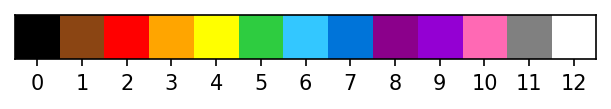

In [4]:
from arckit.vis import test_color

test_color()

# Functions

## IO Functions

In [5]:
def load_json(file_path: Path or str):
    if not isinstance(file_path, str):
        file_path = str(file_path)
    with open(file_path) as f:
        data = json.load(f)
    return data

## Visual Functions

In [6]:
from motion.algorithms import _calculate_optical_flow
from motion.vis_utils import visualize_dense_flow

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda"
dtype = torch.float32

from spatial_correlation_sampler import SpatialCorrelationSampler, spatial_correlation_sample

# <div style="color: white; border: lightgreen solid; font-weight: bold; font-size: 120%; text-align: center; padding: 12.0px; background: black">1. DATA LOADING</div>

In [8]:
dataset_dir = Path('../data/competition')
# dataset_dir = Path('/kaggle/input/arc-prize-2024/')

# train_challenges = load_json(dataset_dir / 'arc-agi_training_challenges.json')
# train_solutions  = load_json(dataset_dir / 'arc-agi_training_solutions.json')

# eval_challenges = load_json(dataset_dir / 'arc-agi_evaluation_challenges.json')
# eval_solutions  = load_json(dataset_dir / 'arc-agi_evaluation_solutions.json')

# test_challenges = load_json(dataset_dir / 'arc-agi_test_challenges.json')

# sample_submission.json

In [9]:
import arckit

train_set, eval_set = arckit.load_data()

# <div  style="color:white; border:lightgreen solid;  font-weight:bold; font-size:120%; text-align:center;padding:12.0px; background:black">2. DATA INSIGHTS</div>

# Grid-Size 

In [10]:
GridSizeDF = pd.DataFrame(columns=['set','task_id','size_in','size_out'])

row = 0
for s, subset in [('train', train_set), ('eval', eval_set)]:
    # if s == 'eval':
    #     continue
    for task in subset:
        I, O = task.train[0]
        GridSizeDF.loc[row] = [s, task.id, I.size, O.size]
        row += 1

        if (len(I.shape) != 2) or (len(O.shape) != 2):
            print(task)

GridSizeDF['comparison'] = (GridSizeDF['size_in'] - GridSizeDF['size_out']).apply(
    lambda x: 'expand' if x < 0 else ('extract' if x > 0 else 'still')
)

display(GridSizeDF.sort_values(by=['size_in','size_out'], ascending=True).T)
display(GridSizeDF[['size_in','size_out']].describe().T)

,105,113,400,476,397,294,210,18,55,102,...,564,632,659,666,680,708,741,780,789,791
set,train,train,eval,eval,train,train,train,train,train,train,...,eval,eval,eval,eval,eval,eval,eval,eval,eval,eval
task_id,46442a0e,49d1d64f,00576224,310f3251,feca6190,bbc9ae5d,8d5021e8,10fcaaa3,27a28665,44f52bb0,...,696d4842,981571dc,ac0c5833,af22c60d,b9630600,ca8f78db,e1d2900e,f3b10344,f8be4b64,f9d67f8b
size_in,4,4,4,4,5,6,6,8,9,9,...,900,900,900,900,900,900,900,900,900,900
size_out,16,16,36,36,100,18,36,32,1,1,...,900,900,900,900,900,900,900,900,900,900
comparison,expand,expand,expand,expand,expand,expand,expand,expand,extract,extract,...,still,still,still,still,still,still,still,still,still,still


,count,mean,std,min,25%,50%,75%,max
size_in,800.0,192.95875,204.784504,4.0,49.0,110.0,247.0,900.0
size_out,800.0,156.16625,192.006163,1.0,25.0,100.0,208.0,900.0


In [24]:
COMP_COLORS = {
    'still': 'darkslategray', 
    'expand': 'red',
    'extract': 'green',
}

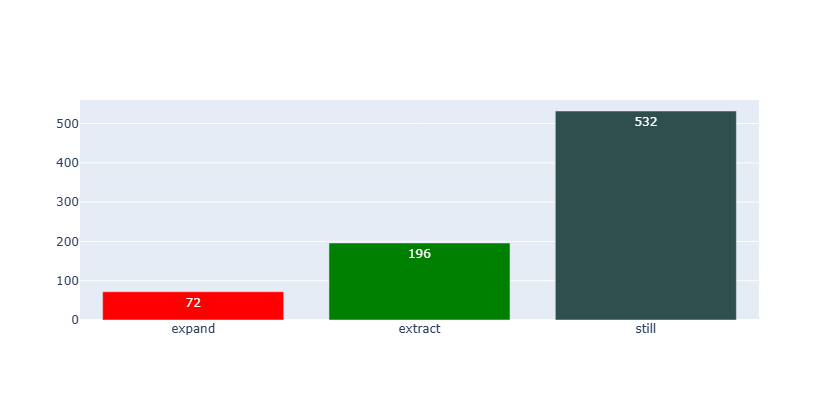

In [26]:
# Meta-Statistics
GridStatsMetaDF = GridSizeDF.groupby(['comparison']).agg({'task_id': 'count'})\
                                         .rename(columns={'task_id': 'count'}).reset_index(drop=False)
GridStatsMetaDF['color'] = GridStatsMetaDF['comparison'].replace(COMP_COLORS)
# display(GridStatsMetaDF)

fig = go.Figure()
fig.add_trace(
        go.Bar(x=GridStatsMetaDF['comparison'],
               y=GridStatsMetaDF['count'],
            text=GridStatsMetaDF['count'], textposition='inside',
    marker_color=GridStatsMetaDF['color'],
))
fig.update_layout(autosize=False, width=690, height=400, )
fig.show()

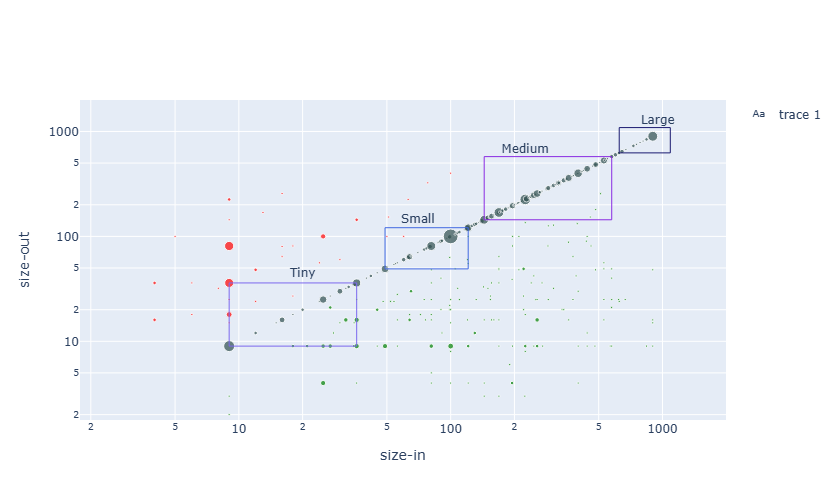

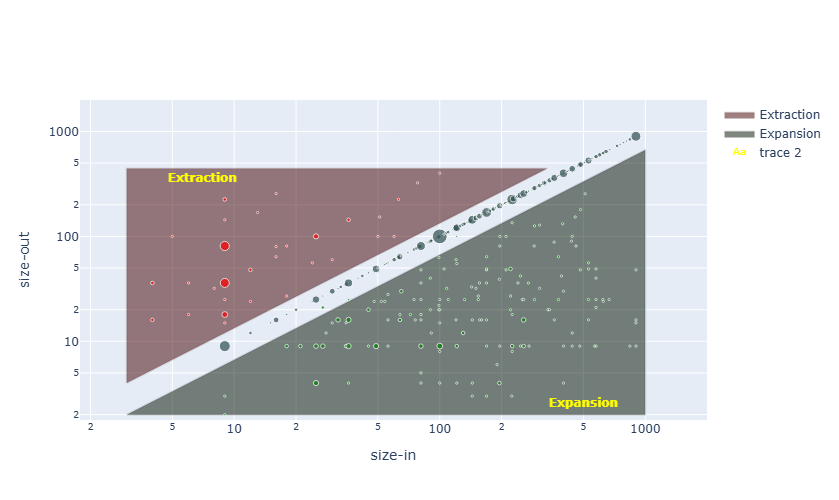

In [32]:
# Distribution
GridStatsDF = GridSizeDF.groupby(['size_in','size_out']).agg({'task_id': 'count', 'comparison': 'first',})\
                                             .rename(columns={'task_id': 'count'}).reset_index(drop=False)
GridStatsDF['color'] = GridStatsDF['comparison'].replace(COMP_COLORS)
# display(GridStatsDF.T)


def plot_distribution(fig = None):

    if fig is None:
        fig = go.Figure()
    
    # Add distribution
    fig.add_trace(
        go.Scatter(x = GridStatsDF['size_in'], 
                   y = GridStatsDF['size_out'],
                text = GridStatsDF['count'],
         marker_size = GridStatsDF['count'].apply(lambda x: np.log2(x+1)*2.25), 
        marker_color = GridStatsDF['color'],
                mode = 'markers', 
          showlegend = False)
    )

    fig.update_layout(width=690, height=500, autosize=False, 
                      xaxis=dict(title="size-in", type="log", range=[0.25, 3.3]), 
                      yaxis=dict(title="size-out", type="log", range=[0.25, 3.3]))

    return fig


"""
Grid-size
"""
fig = plot_distribution()

fig.add_shape(type="rect", x0=9, y0=9, x1=36, y1=36, line=dict(width=1, color="MediumSlateBlue"))
fig.add_shape(type="rect", x0=49, y0=49, x1=121, y1=121, line=dict(width=1, color="RoyalBlue"))
fig.add_shape(type="rect", x0=144, y0=144, x1=576, y1=576, line=dict(width=1, color="BlueViolet"))
fig.add_shape(type="rect", x0=625, y0=625, x1=1089, y1=1089, line=dict(width=1, color="MidnightBlue"))
fig.add_trace(
    go.Scatter(x=[20, 70, 225, 950], 
               y=[44, 144, 666, 1269],
            text=["Tiny","Small","Medium","Large"],
            mode="text",
))

fig.show()

"""
Extraction / Expansion
"""
fig = go.Figure()
fig.add_trace(go.Scatter(x=[3,333,3,3], y=[4,444,444,4], fill="toself", mode='lines', marker_color='rgba(64, 0, 0, .1)', name='Extraction'))
fig.add_trace(go.Scatter(x=[3,999,999,3], y=[2,666,2,2], fill="toself", mode='lines', marker_color='rgba(0, 16, 0, .1)', name='Expansion'))

fig.add_trace(go.Scatter(x=[7, 500], y=[350, 2.5], text=["<b>Extraction</b>","<b>Expansion</b>"], textfont=dict(color='yellow'), mode="text",))

fig = plot_distribution(fig)

fig.show()


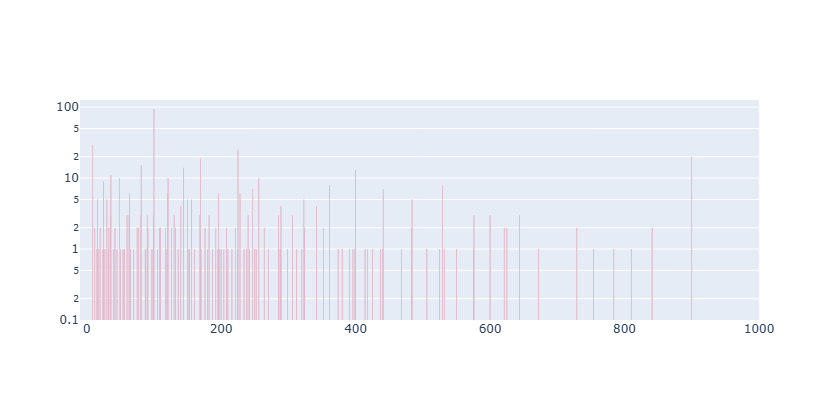

In [28]:
# Segmentation
GridKeepDimDF = GridStatsDF[GridStatsDF['comparison'] == 'still'].reset_index(drop=True)\
                                                                 .rename(columns={'size_in': 'size'})
# display(GridSquaredDF)

fig = go.Figure()
fig.add_trace(
        go.Bar(x=GridKeepDimDF['size'],
               y=GridKeepDimDF['count'],
               marker_color='crimson',
))
fig.update_layout(autosize=False, width=690, height=400, 
                  xaxis=dict(type="linear", range=[-10, 1000]),
                  yaxis=dict(type="log", range=[-1, 2.1]))
fig.show()

# Transformation as **Optical Flow**

In [ ]:
task = deepcopy(train_set['05f2a901'])

for sample_in, sample_out in task.train:

    print(np.unique(sample_in))

    for x in [2, 8]:
        sample_in[sample_in == x] = 1 
        sample_out[sample_out == x] = 1
    sample_in[sample_in != 1] = 0 
    sample_out[sample_out != 1] = 0 
    sample_out[2,1] = 1

    # sample_size = 50
    # sample_in = np.array(Image.fromarray(sample_in).resize((sample_size, sample_size), Image.LANCZOS))
    # sample_out = np.array(Image.fromarray(sample_out).resize((sample_size, sample_size), Image.LANCZOS))
    
    sample_in = (sample_in * 250).astype(np.uint8)
    sample_out = (sample_out * 250).astype(np.uint8)
    # print(sample_in, '\n')
    # print(sample_out, '\n\n')

    sample_stack = np.stack([sample_in, sample_out], axis=0)
    sample_flow = _calculate_optical_flow(sample_stack, method="Farneback")
    # print(sample_flow[..., 0], '\n')
    # print(sample_flow[..., 1], '\n')

    # Visualize
    sample_in_img = sample_in.copy()
    # sample_in_img[sample_in_img > 0] = 250
    sample_flow_img = visualize_dense_flow(sample_flow, mode='color')
    
    display(Image.fromarray(sample_in_img.astype(np.uint8)).resize((500, 500)))
    display(Image.fromarray(sample_flow_img.astype(np.uint8)).resize((500, 500)))
    
    break

# Topic

## <div style="color: #D35142; font-weight: bold; font-size: 100%; text-align :center; padding: 12.0px; background: #ffffff"> Thank you for your reading! </div>
### <div style="color: #D35142; font-weight: bold; font-size: 100%; text-align: center; padding: 12.0px; background: #ffffff"> Please upvote this notebook if you consider it helpful. Your feedback is my motivation to contribute more ! </div>